In [45]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 #version control
!pip install wandb
# !wandb login()

Looking in indexes: https://download.pytorch.org/whl/cu118


# Handling Imports

In [46]:
import torch
import torch.nn as nn                           #imports the neural network module which contains the nn superclass
import torch.optim as optim                     #imports the optimization algorithms such as gradient descent, adam etc
import torch.nn.functional as F                 #has all the parameter-less functions, imports the activation functions(relu etc), but those can also be found in the nn package
from torch.utils.data import DataLoader         #this provides a dataset class for data representation and a dataloader for iterating over the data among other things.
import torchvision.datasets as datasets         #pytorch comes with datasets which can be imported through this
import torchvision.transforms as transforms     #has methods to perform data augmentation operations such as cropping, resizing, normalization etc.

In [47]:
from tqdm import tqdm
# import wandb
import numpy as np

# Creating a CNN

In [48]:
class CNN(nn.Module):
  def __init__(self,in_channels=1,num_classes=10):                                                                       #constructor method which creates the object of the written class
    super(CNN, self).__init__()                                                                                          #super method which inherits the methods from the parent nn.Module class
    self.layers = nn.Sequential(
      nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=5, stride=1, padding=2),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.BatchNorm2d(16),
      nn.ReLU(),
      nn.Dropout(0.25),
      nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Dropout(0.25),
      nn.Flatten(),
      nn.Linear(32*7*7, num_classes)
    )

  def forward(self, x):
    x = self.layers(x)
    return x

# Set Device

In [49]:
 #sets the device to cuda or cpu depending on the avaialability

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Check if the model has any errors in the structure

In [50]:
model = CNN(1, 10).to(device)
# summary(model, (1, 28, 28))

#generates a dummy tensor to check the model parameters
x = torch.randn(64, 1, 28, 28)
# print(model(x).shape)

# Hyperparameters

In [51]:
in_channels = 1
batch_size = 64
learning_rate = 10e-4

#output labels
num_classes = 10

#number of epochs the model is training for
num_epochs = 20

# Transforms

In [52]:
train_transforms = transforms.Compose([ transforms.ToTensor() , transforms.Normalize((0.1307), (0.3081)), transforms.RandomRotation(5), transforms.Resize((30,30)), transforms.CenterCrop((28,28))])

# Load Data

In [53]:
#loading the dataset from pytorch

train_dataset = datasets.MNIST(root='dataset/', train=True, transform=train_transforms, download=True) #downloads the MNIST dataset if it isn't already installed
val_dataset = datasets.MNIST(root='dataset/', train=False, transform=train_transforms, download=True)


# Initialzing Data Loaders

In [54]:
#initialzing the data loaders for train,val and test sets respectively

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

# Initialize Network

In [55]:
#initializing the model

model = CNN().to(device)

# Loss and Optimizer

In [56]:
#choosing the loss function and optimizing algorithm

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train Network

In [57]:
train_losses = []

def train(epoch):

    train_loss=0
    loop = tqdm(train_loader)

    for batch_idx, (data, targets) in enumerate(loop):

        #get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        #forward
        scores = model(data)
        loss = criterion(scores, targets)

        #backward
        optimizer.zero_grad() #so it doesnt store gradients from prev back props
        loss.backward()

        #gradient descent or adam step
        optimizer.step()

        #accumulating loss over an epoch
        train_loss += loss.item()

        loop.set_description(f"Epoch [{epoch}/{num_epochs}]")
        loop.set_postfix(loss=loss.item(), acc=torch.rand(1).item())

    train_loss = train_loss/len(train_loader)

    # storing the train losses over an epoch in a list
    train_losses.append(train_loss)


# Validation Loss


In [58]:
# calculating the loss for val_set

val_losses = []

def val(epoch):

   val_loss=0

   with torch.no_grad():
     for batch_idx, (data, targets) in enumerate(val_loader): # dividing into batches is popssibly unecessary (will check later)

        #calling the model with the val data and calculating the loss
        scores = model(data)
        loss = criterion(scores, targets)

        #accumulating val loss over an epoch
        val_loss += loss.item()

   val_loss = val_loss/len(val_loader)

   # storing the validation losses over epochs in a list
   val_losses.append(val_loss)


# Training the model over epochs


In [59]:
#loops for 20 epochs (will add print statements)

for epoch in range(num_epochs):
    model.train()
    train(epoch)
    model.eval()
    val(epoch)


Epoch [19/20]: 100%|██████████| 938/938 [01:45<00:00,  8.85it/s, acc=0.846, loss=0.0337]


# Accuracy Check

In [60]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    model.train()
    return num_correct / num_samples

# Checking the accuracy on training, validation and test sets


In [61]:
print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:.2f}") #highest was 99.66
print(f"Accuracy on validation set: {check_accuracy(val_loader, model)*100:.2f}")
# print(f"Accuracy on test set: {check_accuracy(test_loader, model)*100:.2f}") #highest was 98.68

Accuracy on training set: 99.56
Accuracy on validation set: 99.27


# Plotting the Train Loss and Validation loss vs number of epochs

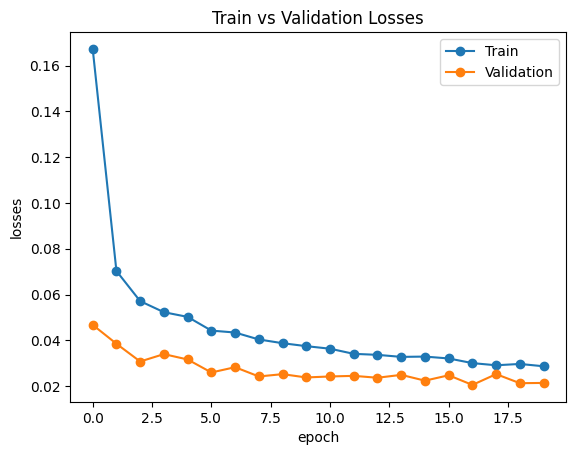

In [62]:
from matplotlib import pyplot as plt

plt.plot(train_losses,'-o')
plt.plot(val_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Validation'])
plt.title('Train vs Validation Losses')

plt.show()

In [63]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [64]:
print(count_parameters(model))

20842
